<a href="https://colab.research.google.com/github/Sharkar96/BHDQN/blob/main/BHDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as r
import numpy as np
import math as m
from numpy import linalg
from shapely.geometry import Point, Polygon, LineString
from shapely import affinity, distance
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import matplotlib.patches as patches
np.set_printoptions(precision=1)

In [2]:
def point2nparray(p: Point):
  return np.array([p.x, p.y])

Parameters

In [54]:
katt=1 #attraction coefficient
kstr=8 #repulsive coefficient
krep=20 #blackhole field coefficient
p0=3 #range of repulsive field
ps=8 #range of blackhole field
W1=-10 #collision penalty
W2=10 #reward of completing goals
W3=-0.2 #penalty for each time
alpha=-20 #reward coefficient of potential field
gamma=0.95 #discount rate
ts=0.06 #sampling time
eps=1 #distance from the goal to be reached
stdDev=1 #standard deviation for the gaussian noise

In [20]:
class Obstacle:
  def __init__(self, o: Point, A):
    self.A=A
    self.o=o
    self.obstacle=None
    self.createObstacle(o, A)

  def contains(self, *arg):
    return self.obstacle.contains(arg)

  def createObstacle(self, o: Point, A):
    th=360*r.random()
    rngLength=(r.random()+0.5)*m.sqrt(A)

    vertex=[]
    vertex.append(Point(o.x-rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y+(A/rngLength)/2))
    vertex.append(Point(o.x-rngLength/2,o.y+(A/rngLength)/2))

    self.obstacle=affinity.rotate(Polygon(vertex),th)

  def polygon2array(self):
    x,y =self.obstacle.exterior.coords.xy
    return[list(a) for a in zip(x,y)]

  def __str__(self):
    return str(self.obstacle)

In [52]:
class Robot:
  def __init__(self, x, y):
    self.x=x
    self.y=y

  def move(self, force: np.ndarray):
    #moves: E, NE, N, NW, W, SW, S, SE
    moves=['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
    possibleMoves= np.array([[1,0],
                             [0.707,0.707],
                             [0,1],
                             [-0.707,0.707],
                             [-1,0],
                             [-0.707,-0.707],
                             [0,-1],
                             [0.707,-0.707]]
                            )

    chosenMove=np.argmax(np.dot(force, possibleMoves.T))
    self.x=self.x + ts*possibleMoves[chosenMove][0]*linalg.norm(force) + np.random.normal(0, stdDev)
    self.y=self.y + ts*possibleMoves[chosenMove][1]*linalg.norm(force) + np.random.normal(0, stdDev)
    print(moves[chosenMove], end=' ')
    print(np.array([self.x, self.y]))
    return

  def __str__(self):
    return str(np.array([self.x,self.y]))

In [46]:
class Maze:
  def __init__(self, A):
    self.l=m.sqrt(A)
    self.coordinates=np.array([[0,0],
                              [self.l,0],
                              [self.l,self.l],
                              [0,self.l]])
    self.obstacles=[]
    self.goals=[]
    self.robot=None

#WHAT ABOUT THE NORMALIZATION OF THE POTENTIAL FIELD?
  def gravitationalForce(self):
    robotPosition=np.array([self.robot.x, self.robot.y])
    resultingF=np.array([0, 0])
    for i in self.goals:
      #attractive force
      normalAttF= -katt*(robotPosition - point2nparray(i))
      #black hole force
      blackHoleF=np.array([0, 0])
      #print(linalg.norm(robotPosition-point2nparray(i)))  #to test blackhole activation
      if linalg.norm(robotPosition-point2nparray(i))<=ps:
        blackHoleF= kstr*(-(robotPosition - point2nparray(i))) #adding ps breaks the implementation
      resultingF= resultingF + normalAttF + blackHoleF

    #repulsive force
    for i in self.obstacles:
      dis=distance(i.obstacle, Point(self.robot.x, self.robot.y)) + 0.01 #for reducing nan in the division
      repulsiveF= np.array([0, 0])
      if dis <= p0:
        repulsiveFmodule=krep*((1/dis)-1/p0)*(1/dis**2)
        p1, p2 = nearest_points(i.obstacle, Point(self.robot.x, self.robot.y))
        repulsiveF=repulsiveFmodule*(point2nparray(p2)-point2nparray(p1))
        print(repulsiveF)
      resultingF= resultingF + repulsiveF
    return resultingF

  #it assumes just 1 robot
  def isGoalReached(self):
    robotPosition= np.array([self.robot.x, self.robot.y])
    for goal in self.goals:
      if linalg.norm(point2nparray(goal)-robotPosition)<=eps:
        return True

    return False

  #check if a goal spawned inside an obstacle
  def isGoalOccluded(self, p: Point):
    for i in self.obstacles:
      if i.contains(p):
        return True
    return False

  #check if the obstacle spawned over a goal
  def isObstacleOccluding(self, p: Polygon):
    for i in self.goals:
      if p.contains(i):
        return True
    return False

  #spawnRobot must be performed after add Obstacles
  def spawnRobot(self, x=None, y=None):
      if x is not None and y is not None:
        if self.isGoalOccluded(Point(x,y)):
          print('Position was eccupied')
        else:
          self.robot=Robot(x,y)
          return

      candidate=Point(r.random()*self.l,r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l,r.random()*self.l)
      self.robot=Robot(candidate.x,candidate.y)

  #addGoals and addObstacles can be performed in every order
  def addGoals(self,n=1):
    for i in range(n):
      candidate=Point(r.random()*self.l, r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l, r.random()*self.l)
      self.goals.append(candidate)

  def addObstacles(self, n=1):
    #maximum area is 7% of entire maze
    maxA=0.07
    for i in range(n):
      candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      while self.isObstacleOccluding(candidate):
        candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      self.obstacles.append(candidate)

  def print(self):
    print('coordinates: '+ str(self.coordinates))
    print('-------------------')
    print('robot: ' + str(self.robot))
    print('-------------------')
    print('goals: ')
    for i in self.goals:
      print(point2nparray(i))
    print('-------------------')
    print('obstacles: ')
    for i in self.obstacles:
      print(i)
    print('-------------------')

  def plot(self):
    plt.clf()
    #plot the maze
    rectangle = patches.Rectangle((0,0), self.l, self.l,
                              linewidth=1, edgecolor='b', facecolor='none')
    plt.gca().add_patch(rectangle)
    #plot robot
    plt.scatter(self.robot.x, self.robot.y, c='b', marker='o', label='Robot')
    #plot goals
    for goal in self.goals:
         circle= patches.Circle((goal.x, goal.y), eps, edgecolor='g', facecolor='lightgreen', linestyle='--')
         plt.gca().add_patch(circle)
         circle= patches.Circle((goal.x, goal.y), ps, edgecolor='black', facecolor='none',linestyle='--', label='blackhole')
         plt.gca().add_patch(circle)
         plt.scatter(goal.x, goal.y, color='darkgreen', marker='x', label='Goal')
    #plot obstacles
    for obs in self.obstacles:
      poly=patches.Polygon(obs.polygon2array(),edgecolor='r', facecolor='r')
      plt.gca().add_patch(poly)
    plt.gca().set_aspect('equal')
    plt.xticks(range(0, m.ceil(self.l),4))
    plt.yticks(range(0, m.ceil(self.l),4))
    plt.xlim(-1, m.ceil(self.l))
    plt.ylim(-1, m.ceil(self.l))
    plt.legend()
    plt.draw()
    plt.pause(0.1)


coordinates: [[ 0.  0.]
 [50.  0.]
 [50. 50.]
 [ 0. 50.]]
-------------------
robot: [40 40]
-------------------
goals: 
[28.9  3.5]
-------------------
obstacles: 
POLYGON ((36.07640089957448 12.241307270002434, 45.620977972654174 11.14066359729041, 46.873630840953474 22.003436121877673, 37.32905376787378 23.104079794589698, 36.07640089957448 12.241307270002434))
POLYGON ((15.05331531350268 14.361796567363896, 16.247808370488126 3.9924332261061473, 26.606660962211038 5.185715503130481, 25.412167905225594 15.55507884438823, 15.05331531350268 14.361796567363896))
POLYGON ((42.51500622764291 7.581681452524041, 38.05045081194308 16.606875027129725, 32.3951122198788 13.809309265231935, 36.85966763557862 4.784115690626248, 42.51500622764291 7.581681452524041))
-------------------


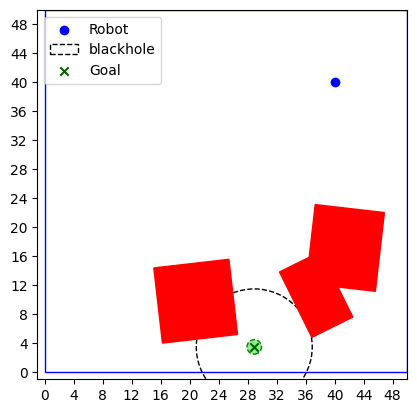

In [66]:
maze=Maze(2500)
maze.addGoals(1)
maze.addObstacles(3)
maze.spawnRobot(x=40,y=40)
maze.print()
maze.plot()


S [37.8 38.4]


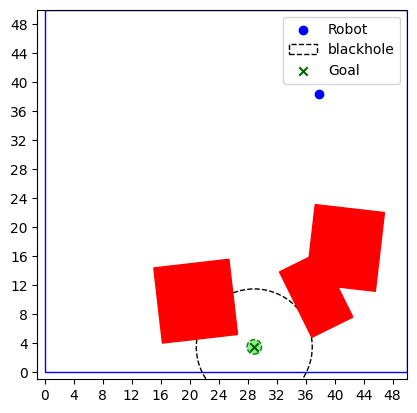

S [37.6 36. ]


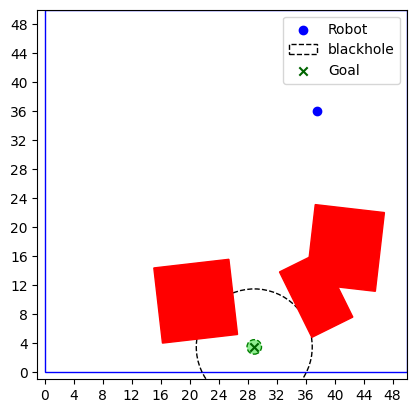

S [38.1 35.9]


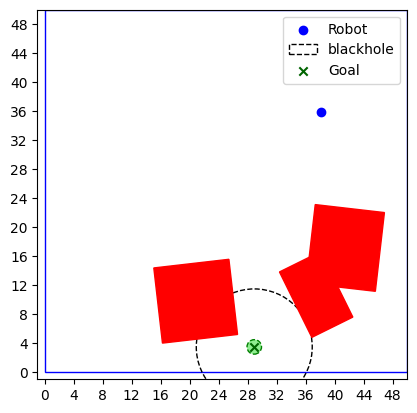

S [38.7 34.2]


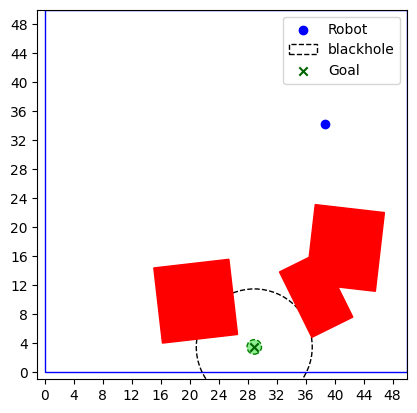

S [36.7 32.7]


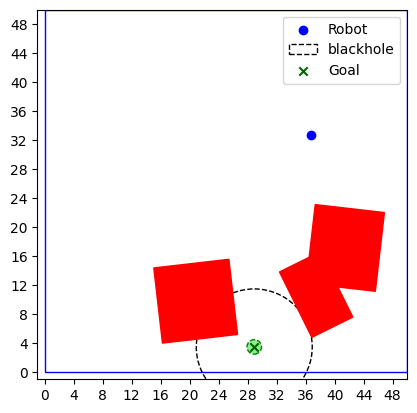

S [36.6 30.1]


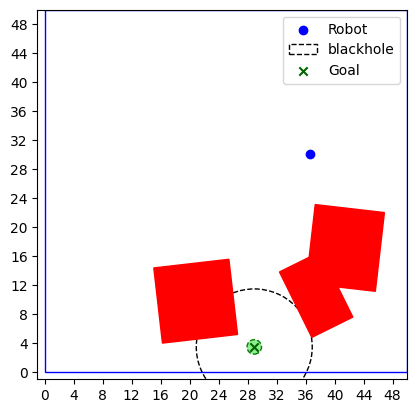

S [36.7 29.4]


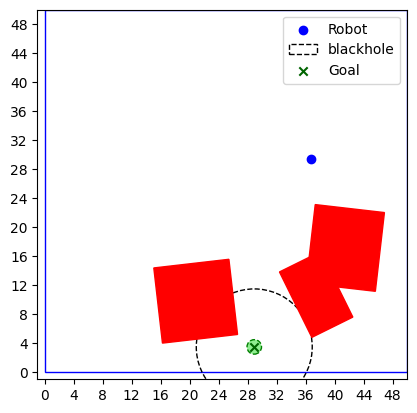

S [36.9 29.5]


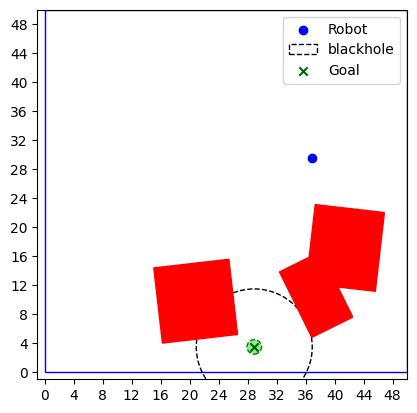

S [38.3 26.8]


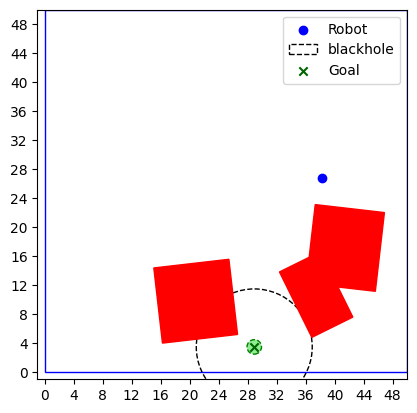

S [38.9 26. ]


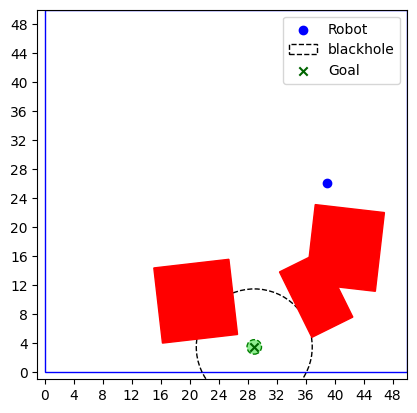

SW [39. 26.]


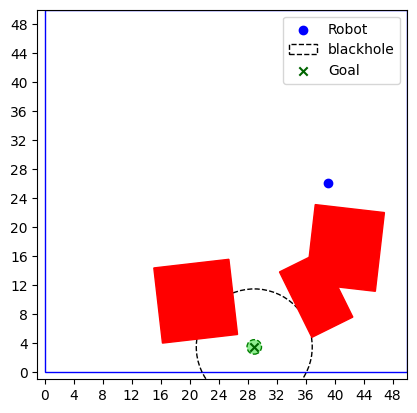

SW [37.4 24.7]


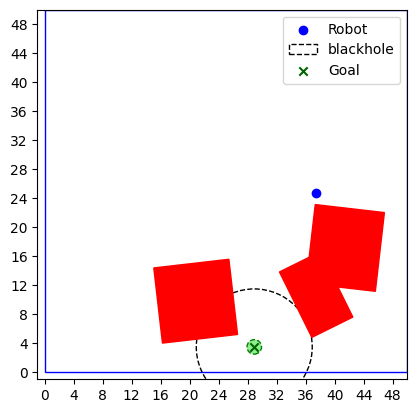

[0.2 3.8]
SW [36.1 22.1]


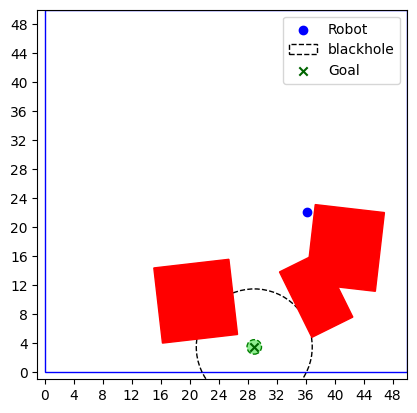

[-10.7   1.2]
SW [33.9 21.8]


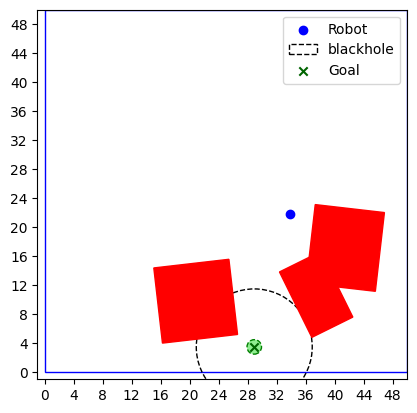

S [33.4 21.4]


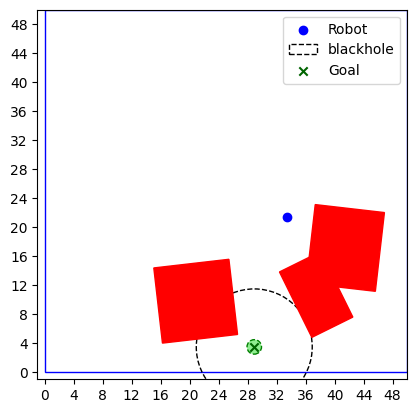

S [34.  21.8]


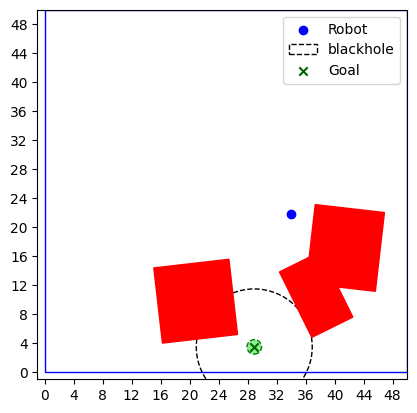

S [32.6 21.1]


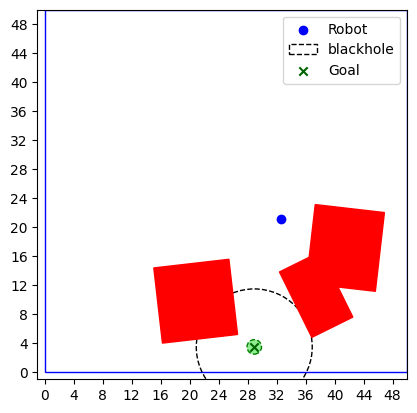

S [33.1 20.9]


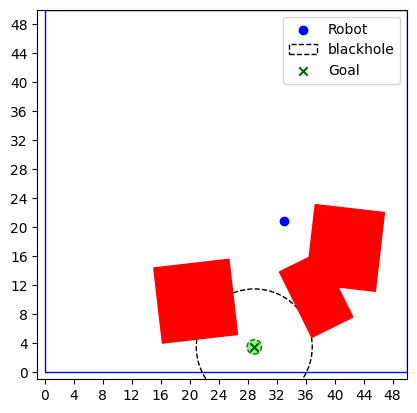

S [35.  20.3]


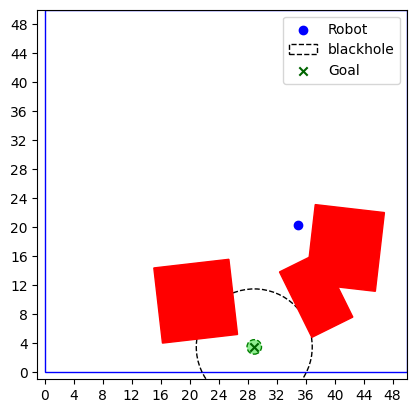

[-1.5  0.2]
SW [33.  20.2]


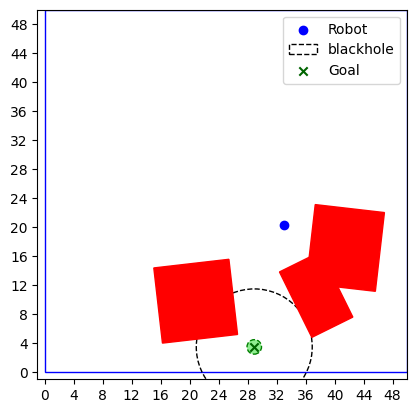

S [33.1 19.1]


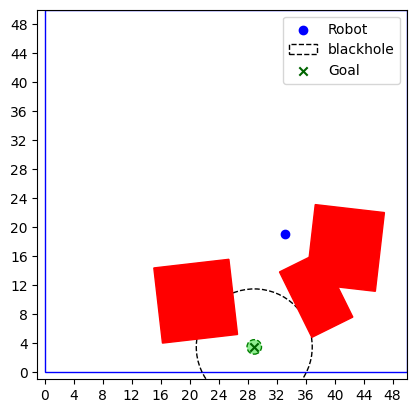

S [33.3 20.8]


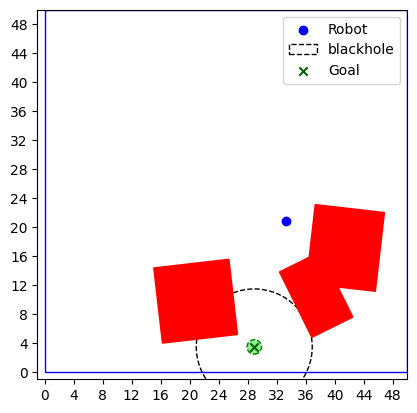

S [34.2 20. ]


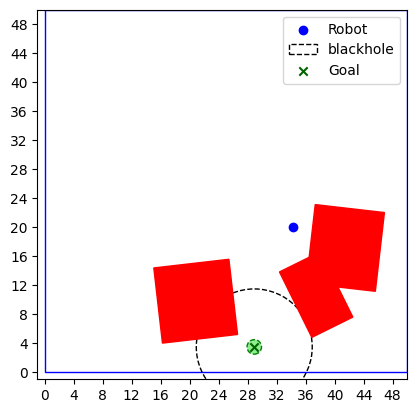

[-0.2  0. ]
S [35.5 17.8]


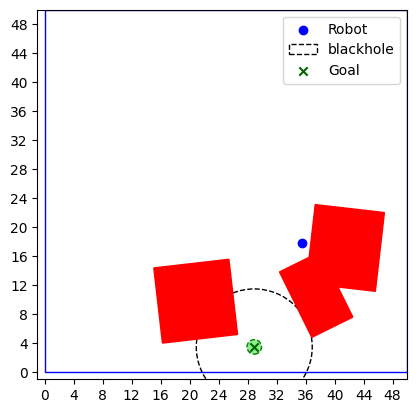

[-8.6  1. ]
[-0.5  1. ]
SW [33.2 16.9]


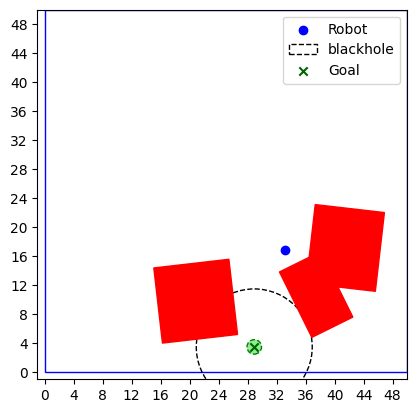

[-0.3  0.6]
S [32.  14.8]


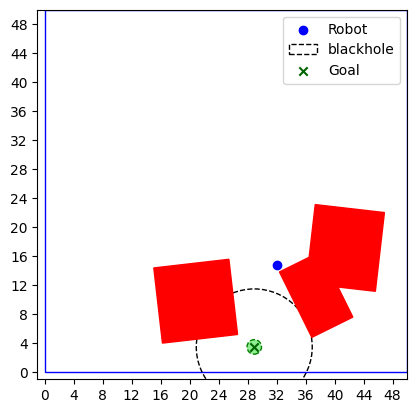

[-5.6 11.4]
W [30.4 14.6]


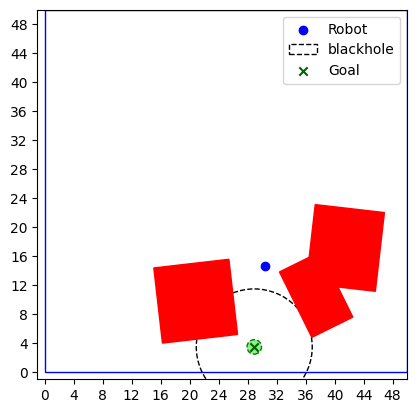

[-1.1  0.5]
S [30.4 14.6]


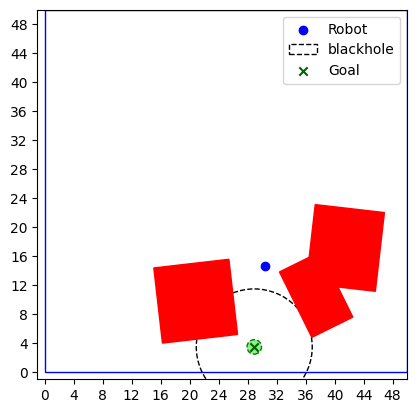

[-1.3  0.5]
S [31.9 14.3]


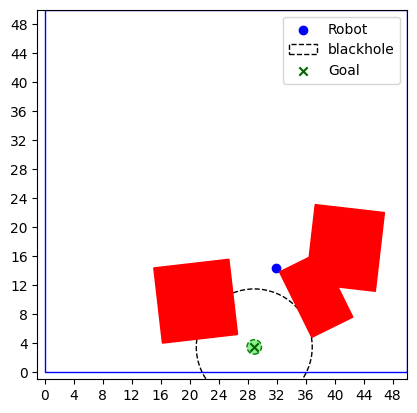

[-22.3  23.7]
NW [30.5 16. ]


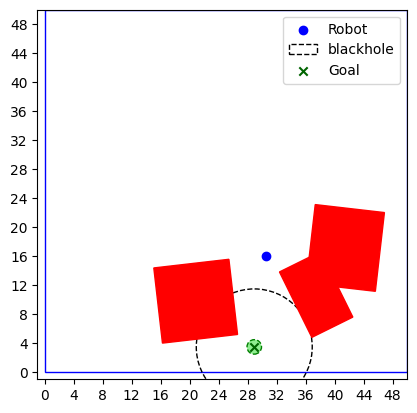

[-0.   0.1]
S [32.4 14.7]


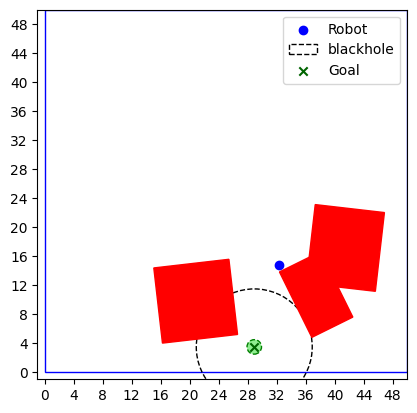

[-8.9 18. ]
NW [31.1 15.7]


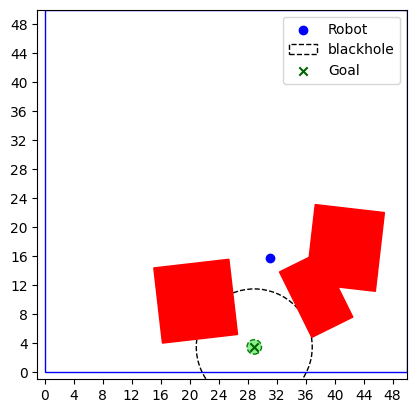

[-0.5  0.7]
S [31.2 15. ]


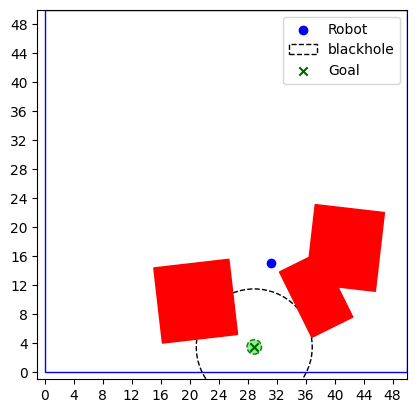

[-2.1  2.1]
SW [30.1 17. ]


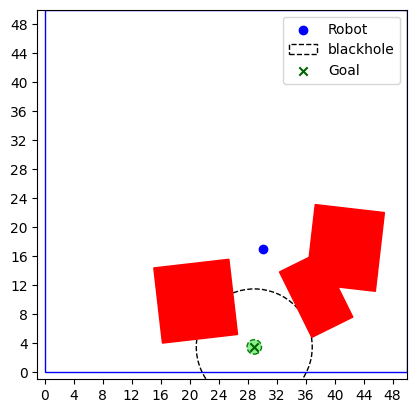

S [31.7 15.6]


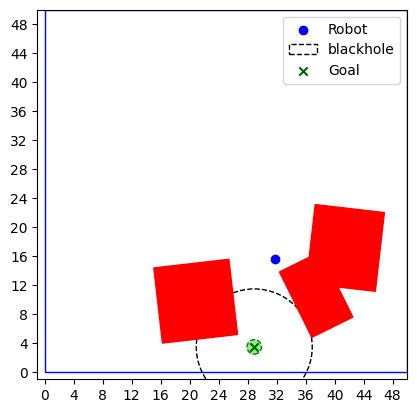

[-0.9  1.9]
S [32.9 16.5]


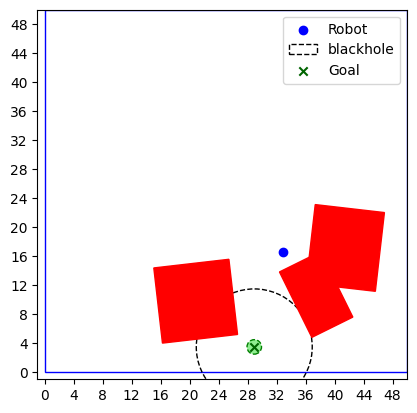

[-0.4  0.9]
S [31.2 16.9]


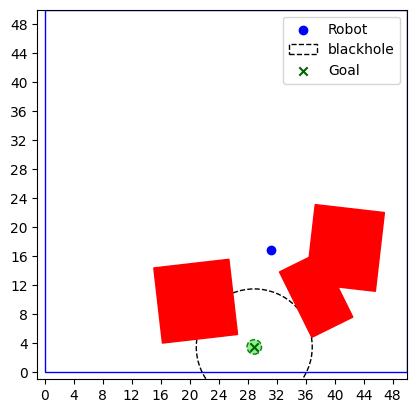

S [29.9 14.6]


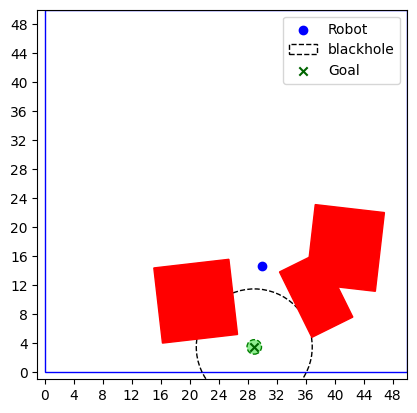

[-0.4  0.1]
S [30.  13.5]


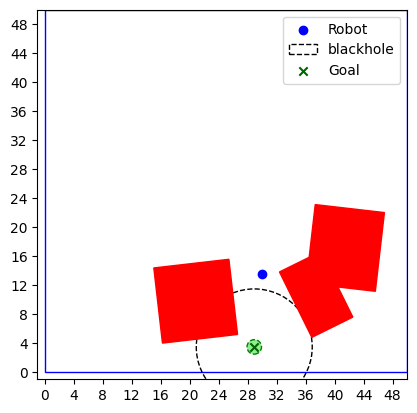

[-0.6 -0.1]
S [29.1 12.9]


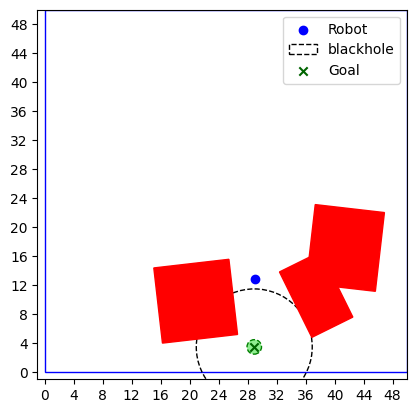

S [28. 12.]


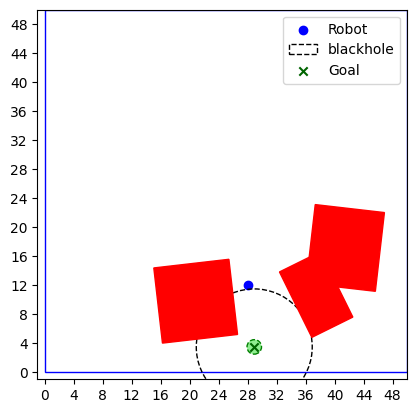

[1.2 0.1]
S [29.4 10.1]


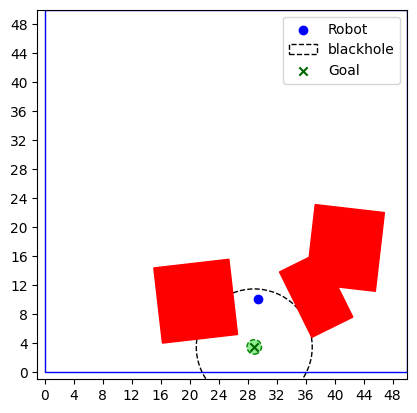

S [27.5  7. ]


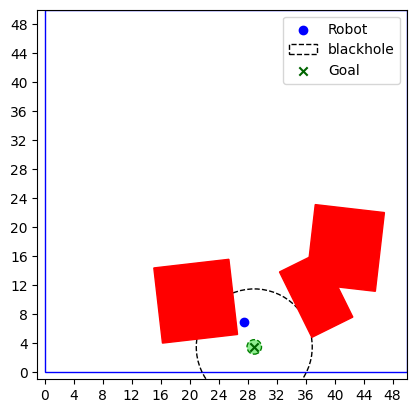

[10.   1.1]
SE [28.3  5.7]


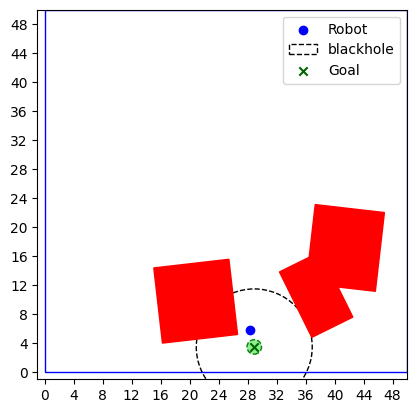

[2.5 0.3]
S [27.8  5.5]


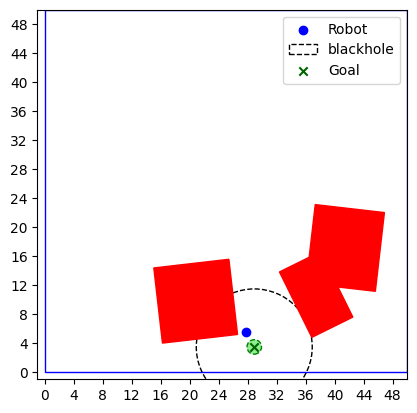

[7.2 0.8]
SE [29.2  7.1]


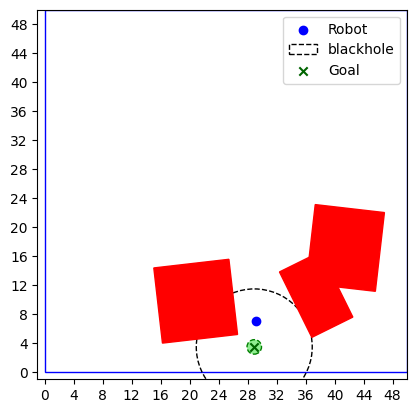

[0.2 0. ]
S [27.5  3.8]


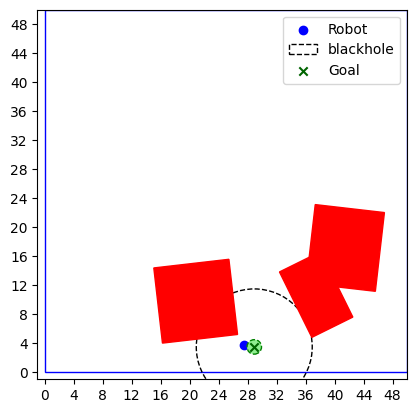

[ 1.7 -2.8]
E [29.4  4. ]


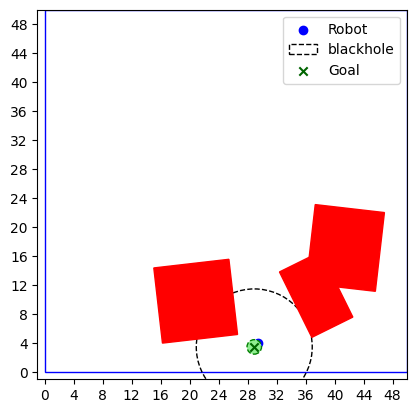

the goal was reached


In [67]:

epochs=50
plt.ion()
for epoch in range(epochs):
  if maze.isGoalReached():
    print('the goal was reached')
    break
  else:
    maze.robot.move(maze.gravitationalForce())
    maze.plot()

plt.ioff()
plt.show()
